## Activation Function-Sigmoid

**Import Library**

In [1]:
import os
import cv2
import random
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

#### Dataset Pre-processing

In [3]:
Y = []
path = "./Dataset/train"
filenames = os.listdir(path)
for img in os.listdir(path):
    val = img.split(".")[0]
    if val == "dog":
        Y.append('1')
    else:
        Y.append('0')

df = pd.DataFrame({
    'filename' : filenames,
    'category' : Y
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [5]:
df.tail()

,filename,category
395,dog.95.jpg,1
396,dog.96.jpg,1
397,dog.97.jpg,1
398,dog.98.jpg,1
399,dog.99.jpg,1


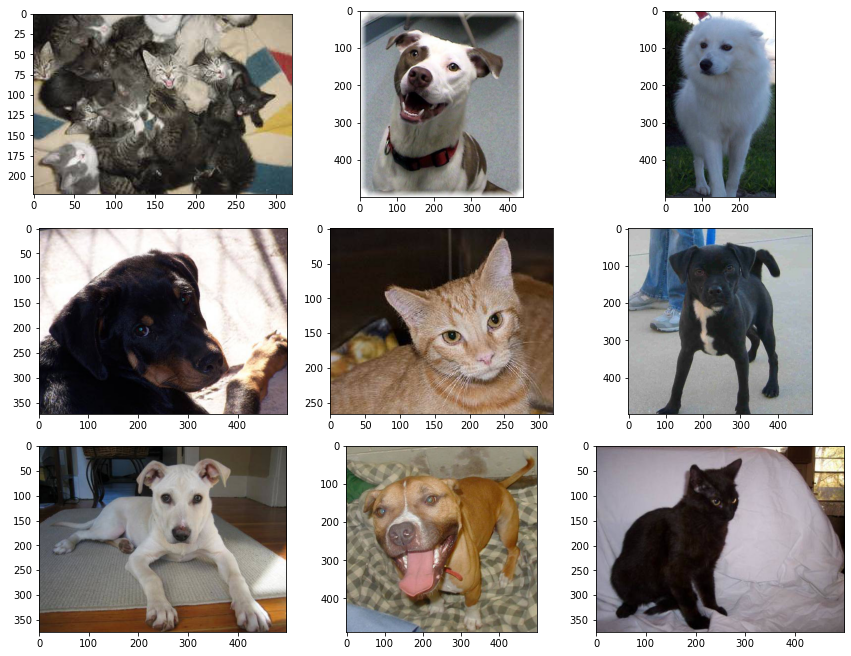

In [6]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    sample = random.choice(filenames)
    filename = path+'/'+sample
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

#### Model Training

In [7]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state = 42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [8]:
train_df.shape

(320, 2)

In [9]:
val_df.shape

(80, 2)

<AxesSubplot:>

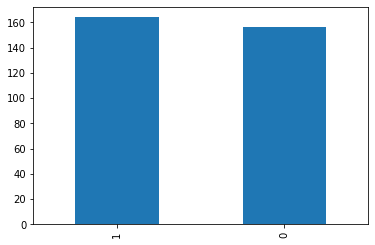

In [10]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

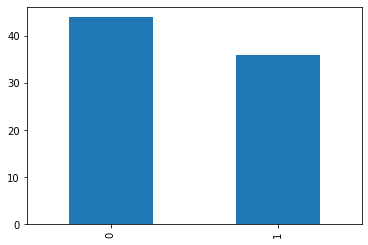

In [11]:
val_df['category'].value_counts().plot.bar()

In [12]:
batch_size = 32
epochs = 30
train_size = train_df.shape[0]
val_size = val_df.shape[0]
img_hieght = 128
img_width = 128
img_channels = 3

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./Dataset/train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 320 validated image filenames belonging to 2 classes.


In [14]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./Dataset/train",
    x_col='filename',
    y_col='category',
    target_size=(img_hieght,img_width),
    class_mode='raw'
)

Found 1 validated image filenames.


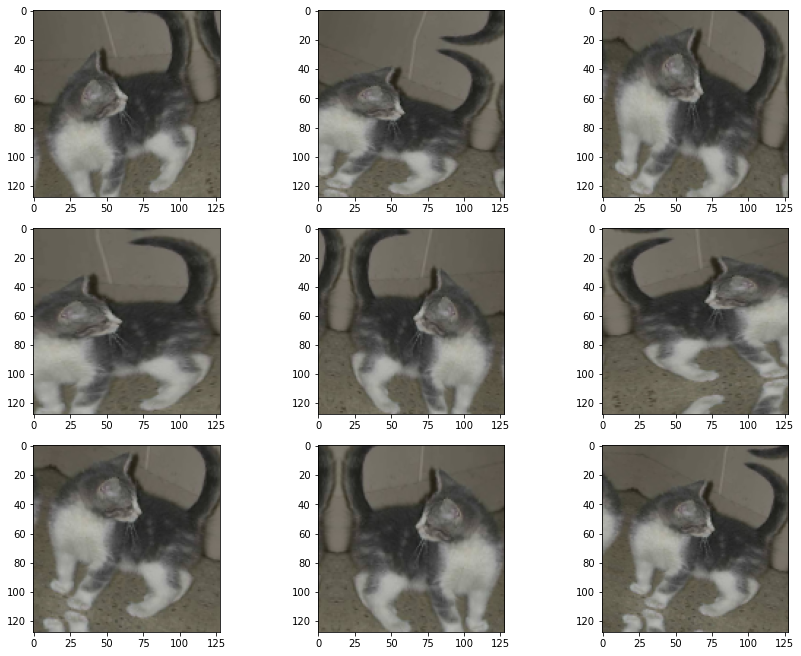

In [15]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    "./Dataset/train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 80 validated image filenames belonging to 2 classes.


#### Model Compiling

In [17]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_hieght,img_width,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)
callbacks = [learning_rate_reduction]

In [20]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data =  val_generator,
    steps_per_epoch = train_size//batch_size,
    validation_steps = val_size//batch_size,
    callbacks = callbacks
)

C:\Users\supri\AppData\Local\Temp/ipykernel_23500/1255825298.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/30
10/10 [==============================] - 12s 1s/step - loss: 1.4650 - accuracy: 0.5500 - val_loss: 0.7115 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 10s 1s/step - loss: 1.0018 - accuracy: 0.6281 - val_loss: 1.0223 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 11s 1s/step - loss: 0.7512 - accuracy: 0.6687 - val_loss: 0.8505 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 10s 1s/step - loss: 0.7074 - accuracy: 0.6969 - val_loss: 2.5818 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7031
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 10s 1s/step - loss: 0.6018 - accuracy: 0.7031 - val_loss: 0.8917 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 12s 1s/step - loss: 0.52

#### Model Evaluation

In [24]:
score = model.evaluate_generator(val_generator)
print(score[1]*100)

C:\Users\supri\AppData\Local\Temp/ipykernel_23500/4056359736.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(val_generator)


55.000001192092896


In [25]:
score = model.evaluate_generator(train_generator)
print(score[1]*100)

C:\Users\supri\AppData\Local\Temp/ipykernel_23500/92563152.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator)


49.06249940395355


In [26]:
conf_datagen = ImageDataGenerator(
    rescale = 1./255,
)

conf_generator = conf_datagen.flow_from_dataframe(
    val_df,
    "./Dataset/train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary'
)

Found 80 validated image filenames belonging to 2 classes.


In [27]:
y_predict = model.predict_generator(conf_generator)

C:\Users\supri\AppData\Local\Temp/ipykernel_23500/652915762.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = model.predict_generator(conf_generator)


In [28]:
y_predict = np.where(y_predict > 0.5, 1, 0)

In [29]:
p = conf_generator.classes
q = y_predict
p = np.array(p)
q = q.flatten()

#### Confusion Matrix

[[44  0]
 [36  0]]


[Text(0, 0.5, 'cats'), Text(0, 1.5, 'dogs')]

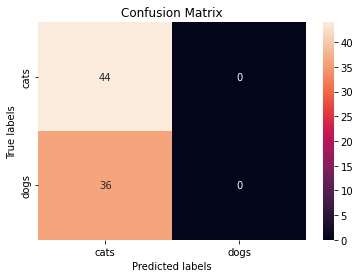

In [30]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

#### Classification Matrix

In [31]:
print(classification_report(p,q))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        44
           1       0.00      0.00      0.00        36

    accuracy                           0.55        80
   macro avg       0.28      0.50      0.35        80
weighted avg       0.30      0.55      0.39        80



C:\Users\supri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\supri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\supri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
